***Import Libraries***

In [1]:
"""This program bilinearizes 3R planar dyanmics using koopman theory and autoencoder to map"""
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import scipy.io
import torch

# bilinear Koopman
from core.koopman_core import KoopDNN, KoopmanNet, KoopmanNetCtrl
from models.koop_model import model_matricies,lift
from core.util import fit_standardizer
from sklearn import preprocessing

# forward map neural net
from core.neural_fwd_map import map_Net


## import paths
from paths.paths import path_pars


### Load Data

In [2]:
data = scipy.io.loadmat('dynamics/Dataset_MATLAB/2D/data.mat')

X_end = np.array(data['X_end'], dtype = 'float64')
X_full = np.array(data['X'], dtype = 'float64')
U_full = np.array(data['tau_red'], dtype = 'float64')

print(X_end.shape, X_full.shape,U_full.shape)

(100, 1001, 3) (100, 1001, 14) (100, 1000, 3)


In [3]:
np.sum(np.sum(np.isnan(X_end))), np.sum(np.sum(np.isnan(U_full))), np.sum(np.sum(np.isnan(X_full)))

(0, 0, 0)

***Simulation Parameters***

In [4]:
dt = float(data['dt']) #time step
num_snaps = int(data['num_snaps']) # no. of snapshots
num_traj = int(data['num_traj']) #no of trajectories
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = int(0.75*num_traj) # no. of training examples
num_val = num_traj-num_train # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = X_full.shape[2] # no. of states
num_inputs = U_full.shape[2] # no. of inputs

In [5]:
dt, num_snaps, num_traj, num_states, num_inputs

(0.005, 1000, 100, 14, 3)

***Plotting the trajectories***

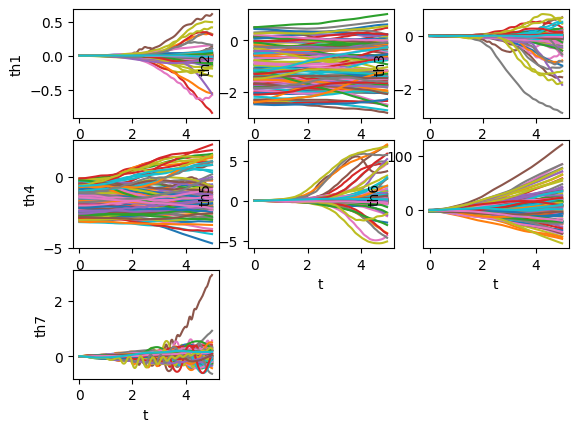

In [6]:
"""Training dataset visualization"""
#theta evolution
for i in range(int(num_states/2)):
    plt.subplot(3,3,i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1))
    for j in range(num_traj):
        plt.plot(T,X_full[j,:,i])

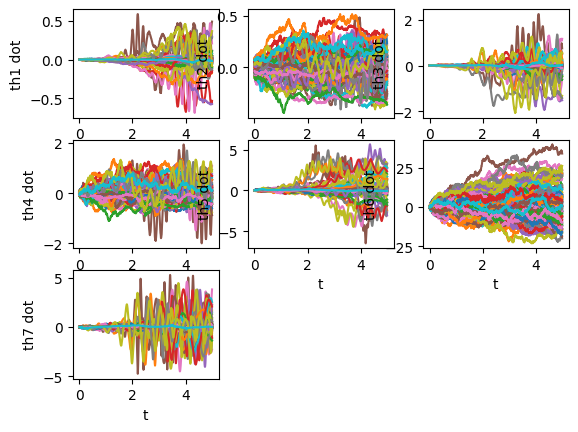

In [7]:
for i in range(int(num_states/2)):
    plt.subplot(3,3,i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1)+ ' dot')
    for j in range(num_traj):
        plt.plot(T,X_full[j,:,i+int(num_states/2)])

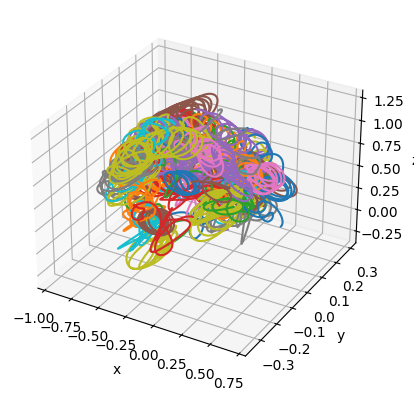

In [8]:
#x and y positions of the end effector
ax = plt.axes(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
for i in range(num_traj):
    ax.plot3D(X_end[i,:,0],X_end[i,:,1],X_end[i,:,2])

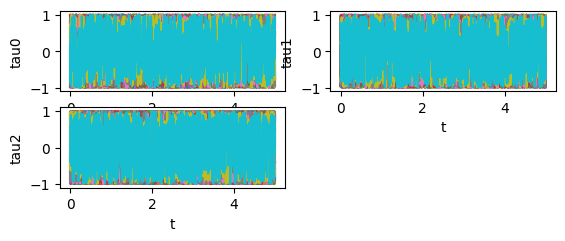

In [9]:
for i in range(num_inputs):
    plt.subplot(4,2,i+1)
    plt.xlabel("t")
    plt.ylabel("tau"+str(i))
    for j in range(num_traj):
        plt.plot(T[:-1],U_full[j,:,i])

***Training and validation datasets***

In [10]:
# split training and vaidation datasets
xs_train, us_train = X_full[:num_train,:,:],U_full[:num_train,:,:]
xs_val, us_val = X_full[num_train:,:,:],U_full[num_train:,:,:]

In [11]:
# import scipy.io
# Data_set = {"x_end": X_end, "X_full": X_full}
# scipy.io.savemat("Data_set.mat",Data_set)

In [12]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

***Model Training***

In [13]:
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 80
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 30
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 5e-4 # 5e-4
net_params['epochs'] = 2000
net_params['batch_size'] = 128
net_params['lifted_loss_penalty'] = 0.4 
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = False
net_params['override_C'] = True # this makes the state a part of lifetd state
net_params['dt'] = dt

In [14]:
train = True

if train == True:
    file = 'saved_models/Kuka/2D/koop_arch.pth'
    # standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean=False))
    # net = KoopmanNetCtrl(net_params, standardizer_u=standardizer_u_kdnn)
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'saved_models/Kuka/2D/koop_arch.pth'
    model_koop_dnn = torch.load(file)


Epoch   1: train loss: 1.2744902372, validation loss: 0.6155008693
Epoch   2: train loss: 0.5433792472, validation loss: 0.4012905752
Epoch   3: train loss: 0.4311011136, validation loss: 0.3285130791
Epoch   4: train loss: 0.3804796040, validation loss: 0.3004631821
Epoch   5: train loss: 0.3628878891, validation loss: 0.2919489237
Epoch   6: train loss: 0.3542950451, validation loss: 0.2868574920
Epoch   7: train loss: 0.3451307714, validation loss: 0.2838693921
Epoch   8: train loss: 0.3354796469, validation loss: 0.2785661393
Epoch   9: train loss: 0.3227140605, validation loss: 0.2951068044
Epoch  10: train loss: 0.3073359132, validation loss: 0.2737416074
Epoch  11: train loss: 0.2920306325, validation loss: 0.2720572706
Epoch  12: train loss: 0.2812032998, validation loss: 0.2778551331
Epoch  13: train loss: 0.2696121931, validation loss: 0.2805912775
Epoch  14: train loss: 0.2586867511, validation loss: 0.2679228649
Epoch  15: train loss: 0.2501258552, validation loss: 0.266478

***Learning Curves***

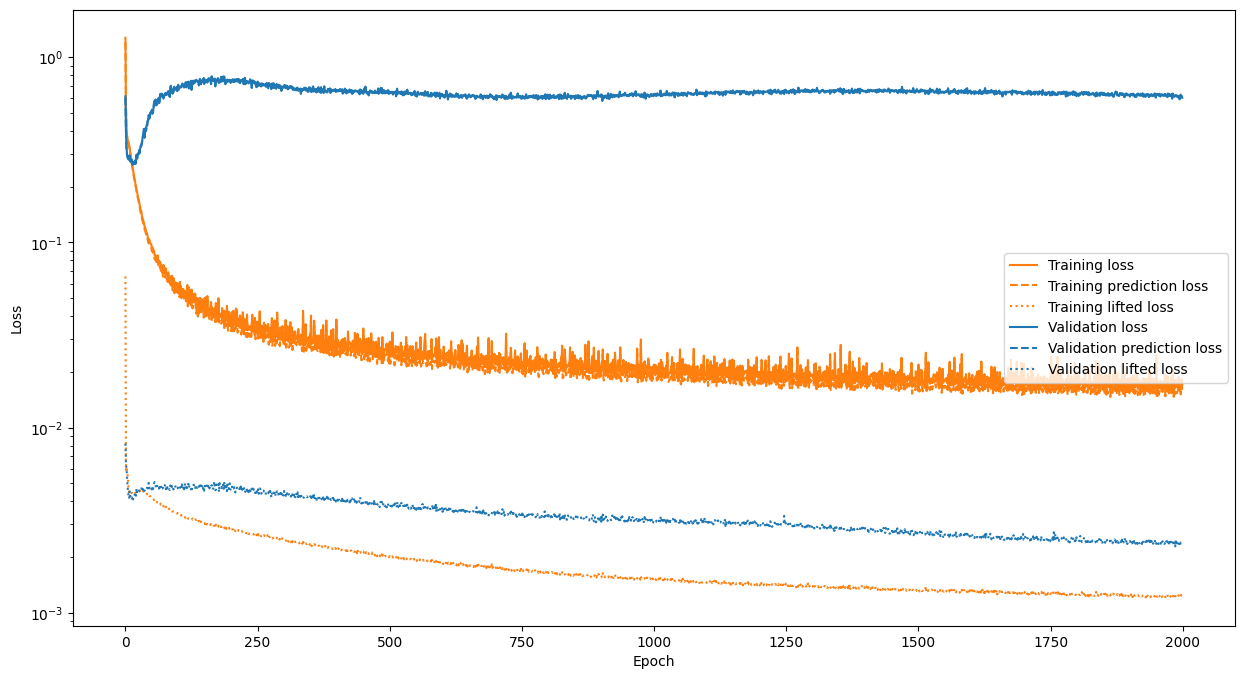

In [20]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot for arch1")
plt.show()


In [21]:
map_net_params = {}
map_net_params["input_dim"] = int(num_states/2) #number of joint angles
map_net_params["output_dim"] = X_end.shape[2] #x and y position of the end effector
map_net_params["hidden_width"] = 20
map_net_params["hidden_depth"] = 2
map_net_params["batch_size"] = 100
map_net_params["epochs"] = 500
map_net_params["activation_type"] = 'tanh'
map_net_params["lr"] = 1e-3
map_net_params["optimizer"] = 'adam'
map_net_params['l2_reg'] = 0.0
map_net_params['l1_reg'] = 0.0

In [22]:
#dataset
# split training and vaidation datasets
xs_map_train, ys_map_train = X_full[:num_train,:,:7],X_end[:num_train,:,:3]
xs_map_val, ys_map_val = X_full[num_train:,:,:7],X_end[num_train:,:,:3]

In [23]:
ys_map_train.shape, ys_map_val.shape,xs_map_train.shape, xs_map_val.shape

((75, 1001, 3), (25, 1001, 3), (75, 1001, 7), (25, 1001, 7))

Epoch   1: train loss: 0.0283958286, validation loss: 0.0140733872
Epoch   2: train loss: 0.0070849972, validation loss: 0.0109293826
Epoch   3: train loss: 0.0053236233, validation loss: 0.0094493714
Epoch   4: train loss: 0.0046258906, validation loss: 0.0085300060
Epoch   5: train loss: 0.0042699536, validation loss: 0.0088714348
Epoch   6: train loss: 0.0040662407, validation loss: 0.0080833414
Epoch   7: train loss: 0.0039009292, validation loss: 0.0073472990
Epoch   8: train loss: 0.0037498462, validation loss: 0.0072892713
Epoch   9: train loss: 0.0036884411, validation loss: 0.0066262894
Epoch  10: train loss: 0.0035957603, validation loss: 0.0067254053
Epoch  11: train loss: 0.0035135736, validation loss: 0.0059171038
Epoch  12: train loss: 0.0034903259, validation loss: 0.0060590164
Epoch  13: train loss: 0.0034292632, validation loss: 0.0066902060
Epoch  14: train loss: 0.0034154669, validation loss: 0.0058829718
Epoch  15: train loss: 0.0033540982, validation loss: 0.005937

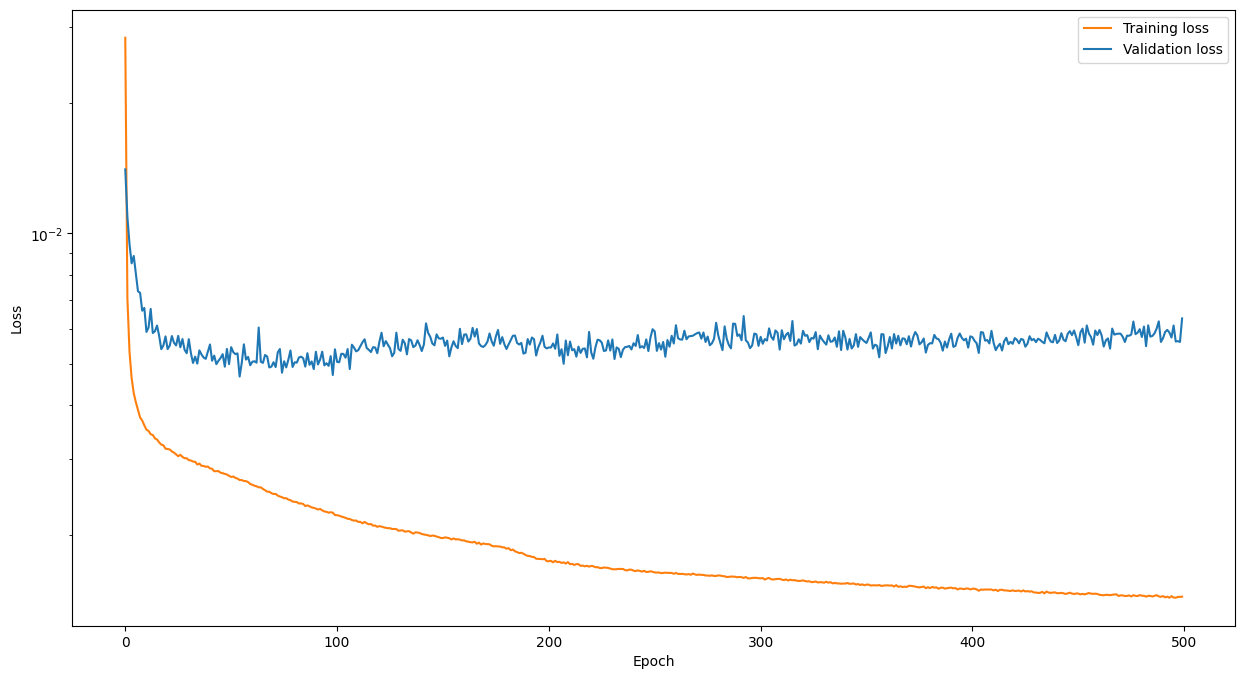

In [24]:
#Initalize network
#Initalize network
train = True

if train==True:
    file = "saved_models/Kuka/2D/map_net.pth"
    map_net = map_Net(map_net_params)
    map_net.set_dataset_map(xs_map_train,ys_map_train,xs_map_val,ys_map_val)
    map_net.data_pipeline()
    map_net.plot_loss()
    torch.save(map_net.state_dict(),file)
else:
    file = "saved_models/Kuka/2D/map_net.pth"
    map_net = map_Net(map_net_params)
    map_net.load_state_dict(torch.load(file))


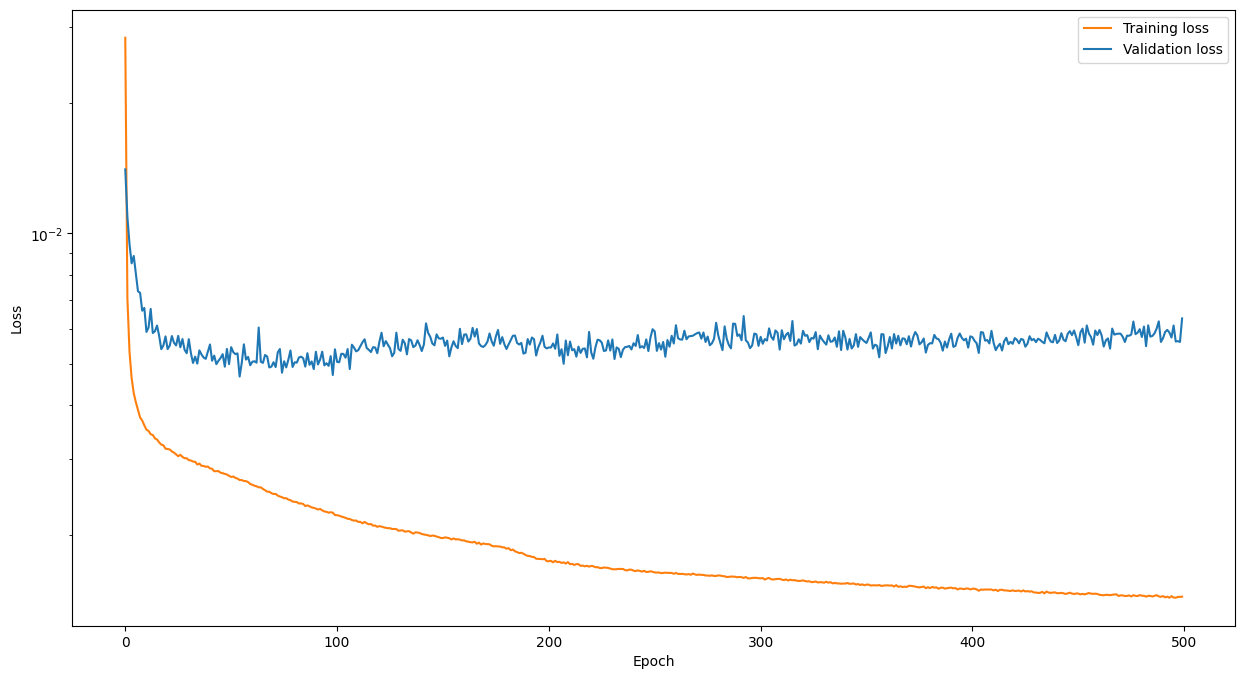

In [25]:
epochs = np.arange(0, map_net_params['epochs'])
plt.figure(figsize=(15,8))
plt.plot(epochs, map_net.train_loss_hist, color='tab:orange', label='Training loss')
plt.plot(epochs, map_net.val_loss_hist, color='tab:blue', label='Validation loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot of map net for arch1[3,20,20,2]")
plt.show()

In [26]:
# import scipy.io

# #save net parameters
# scipy.io.savemat("map_in_weights.mat", {"map_in_weights": map_net.map_net_in.weight.detach().numpy()})
# scipy.io.savemat("map_in_bias.mat", {"map_in_bias": map_net.map_net_in.bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_1.mat",
#                  {"map_hidden_weights_1": map_net.map_net_hid[0].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_1.mat",
#                  {"map_hidden_bias_1": map_net.map_net_hid[0].bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_2.mat",
#                  {"map_hidden_weights_2": map_net.map_net_hid[1].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_2.mat",
#                  {"map_hidden_bias_2": map_net.map_net_hid[1].bias.detach().numpy()})

# scipy.io.savemat("map_hidden_weights_3.mat",
#                  {"map_hidden_weights_3": map_net.map_net_hid[2].weight.detach().numpy()})
# scipy.io.savemat("map_hidden_bias_3.mat",
#                  {"map_hidden_bias_3": map_net.map_net_hid[2].bias.detach().numpy()})

# scipy.io.savemat("map_out_weights.mat", {"map_out_weights": map_net.map_net_out.weight.detach().numpy()})
# scipy.io.savemat("map_out_bias.mat", {"map_out_bias": map_net.map_net_out.bias.detach().numpy()})

## Test Data Parameters

In [27]:
# test data parameters
num_snaps_val = 100 # no. of snapshots
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)
num_traj_val = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

***Koopman Bilinear Model***


In [28]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(44, 44) (44, 132) (14, 44)


In [29]:
# #SAVE MATRIX PARAMETERS AS MATLAB FILE
# import scipy.io

# dyn_matrices = {"A": A, "B": B, "C": C}
# scipy.io.savemat("dyn_mat.mat", dyn_matrices)
# #save encoder parameters
# scipy.io.savemat("in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
# scipy.io.savemat("in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})

# scipy.io.savemat("hidden_weights_1.mat",
#                  {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_1.mat",
#                  {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})

# scipy.io.savemat("hidden_weights_2.mat",
#                  {"encode_hidden_weights_2": model_koop_dnn.net.encoder_fc_hid[1].weight.detach().numpy()})
# scipy.io.savemat("hidden_bias_2.mat",
#                  {"encode_hidden_bias_2": model_koop_dnn.net.encoder_fc_hid[1].bias.detach().numpy()})

# scipy.io.savemat("out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
# scipy.io.savemat("out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

In [30]:
encode_out_bias = model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()
encode_out_weights = model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()

***Test Data Generation***

In [31]:
# data_gen
j = 60
xs_end_test = X_end[j,:,:]
xs_test = X_full[j,:,:]
us_test = U_full[j,:,:]

In [32]:
print(xs_end_test.shape, xs_test.shape, us_test.shape)

(1001, 3) (1001, 14) (1000, 3)


In [33]:
print(model_koop_dnn.test_loss(xs_test.reshape(1,-1,num_states),u_test = us_test.reshape(1,-1,num_inputs)))

tensor(0.0095)


In [34]:
basis = model_koop_dnn.net.encode_forward_

In [35]:
X,_ = model_koop_dnn.net.process(xs_test.reshape(1,-1,num_states),data_u = us_test.reshape(1,-1,num_inputs))
print(X.shape)

(1000, 31)


In [36]:
x = X[:, :num_states]
u = X[:, num_states:num_states+num_inputs]
x_prime = X[:,num_states+num_inputs:]

print(x.shape, u.shape, x_prime.shape)

(1000, 14) (1000, 3) (1000, 14)


***Initial Condition Lifting***

In [ ]:
# initialize the matricies
z = np.empty((n_obs,num_snaps_val+1)).T
x_est = np.zeros((num_states,num_snaps_val+1)).T
x_end_est = np.zeros((X_end.shape[2],num_snaps_val)).T

In [ ]:
z[0,:] = lift(x[0,:],model_koop_dnn, net_params)
x_est[0,:] = x[0,:]

***Time Evolution***

In [ ]:
for i in range(num_snaps_val):
  #bilinear
    z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(np.kron(u[i,:],z[i,:]),B.T)
    x_est[i+1,:] = np.matmul(z[i+1,:],C.T)  
    x_end_est[i,:] = map_net.forward(torch.from_numpy(x_est[i,:int(num_states/2)]).float()).detach().numpy()

***Visualization***

# Joint Space

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,0],label ='Actual')
plt.plot(T,x_est[:,0],label = 'estimated(bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,1],label ='Actual')
plt.plot(T,x_est[:,1],label = 'estimated(bilinear)')
plt.title('Theta_2')
plt.xlabel('t')
plt.ylabel('Theta_2_comparison')
plt.legend()

In [ ]:

plt.figure()
plt.plot(T[:-1],x[:,2],label ='Actual')
plt.plot(T,x_est[:,2],label = 'estimated(bilinear)')
plt.title('Theta_3')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,3],label ='Actual')
plt.plot(T,x_est[:,3],label = 'estimated(bilinear)')
plt.title('Theta_4')
plt.xlabel('t')
plt.ylabel('theta_4')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,4],label ='Actual')
plt.plot(T,x_est[:,4],label = 'estimated(bilinear)')
plt.title('Theta_5')
plt.xlabel('t')
plt.ylabel('theta_5')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,5],label ='Actual')
plt.plot(T,x_est[:,5],label = 'estimated(bilinear)')
plt.title('Theta_6')
plt.xlabel('t')
plt.ylabel('theta_6')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,6],label ='Actual')
plt.plot(T,x_est[:,6],label = 'estimated(bilinear)')
plt.title('Theta_6')
plt.xlabel('t')
plt.ylabel('theta_6')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,7],label ='Actual')
plt.plot(T,x_est[:,7],label = 'estimated(bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.title('theta_1_dot Comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,8],label ='Actual')
plt.plot(T,x_est[:,8],label = 'estimated(bilinear)')
plt.title('Theta_2_dot')
plt.xlabel('t')
plt.ylabel('Theta_2_dot_comparison')
plt.legend()

In [ ]:

plt.figure()
plt.plot(T[:-1],x[:,9],label ='Actual')
plt.plot(T,x_est[:,9],label = 'estimated(bilinear)')
plt.title('Theta_3_dot')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,10],label ='Actual')
plt.plot(T,x_est[:,10],label = 'estimated(bilinear)')
plt.title('Theta_4_dot')
plt.xlabel('t')
plt.ylabel('theta_4_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,11],label ='Actual')
plt.plot(T,x_est[:,11],label = 'estimated(bilinear)')
plt.title('Theta_5_dot')
plt.xlabel('t')
plt.ylabel('theta_5_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,12],label ='Actual')
plt.plot(T,x_est[:,12],label = 'estimated(bilinear)')
plt.title('Theta_6_dot')
plt.xlabel('t')
plt.ylabel('theta_6_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x[:,13],label ='Actual')
plt.plot(T,x_est[:,13],label = 'estimated(bilinear)')
plt.title('Theta_7_dot')
plt.xlabel('t')
plt.ylabel('theta_7_dot')
plt.legend()

In [ ]:
map_net.forward(torch.from_numpy(x_est[1,0:7]).float()).detach().numpy()


## Cartesian Space

In [ ]:
plt.figure()
plt.plot(T,xs_end_test[:,0], label = 'Actual')
plt.plot(T[:-1],x_end_est[:,0], label = 'Estimated')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(T,xs_end_test[:,1], label = 'Actual')
plt.plot(T[:-1],x_end_est[:,1], label = 'Estimated')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(T,xs_end_test[:,2], label = 'Actual')
plt.plot(T[:-1],x_end_est[:,2], label = 'Estimated')
plt.legend()
plt.show()